# **Improved DeepFake Detection with Effectiveness**

# Part3. DeepFake Detection Model

**Detection모델의 실험 과정의 대표 코드입니다. 본 코드에서는 데이터셋은 Celeb-DF, 모델은 ResNet50, 채널은 Gray Channel을 이용하였습니다.**

### Library Import

In [1]:
!pip install pytorch-lightning
!pip install lightning-bolts
!pip install torch_summary

     |████████████████████████████████| 525 kB 9.9 MB/s 
     |████████████████████████████████| 829 kB 82.6 MB/s 
     |████████████████████████████████| 132 kB 68.4 MB/s 
     |████████████████████████████████| 596 kB 60.5 MB/s 
     |████████████████████████████████| 332 kB 97.6 MB/s 
     |████████████████████████████████| 1.1 MB 47.7 MB/s 
     |████████████████████████████████| 271 kB 82.3 MB/s 
     |████████████████████████████████| 160 kB 72.6 MB/s 
     |████████████████████████████████| 192 kB 78.2 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=dd67273fe292e94a505e490cc911459b29737245d86846b65dcbe9f03e475919
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [22]:
# 데이터 보기
import pandas as pd
import numpy as np
from glob import glob

# 이미지데이터 로딩
from PIL import Image
import cv2
from tqdm import tqdm

# random
import random

# 파일경로 설정
import os
import json

# Others
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt


# torch
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, SequentialSampler
from torchvision import datasets, models, transforms
from random import seed,shuffle
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

# pytorch lightning
from pl_bolts.models.self_supervised import SimCLR
from pl_bolts.models.self_supervised.simclr import SimCLREvalDataTransform, SimCLRTrainDataTransform


In [3]:
# !mkdir /content/drive/MyDrive/DeepFake_Detection_research/Celeb-DF-v2-unseen

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/Deepfake_Detection/Celeb-DF-v2.zip #-d path

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: YouTube-real/00288/00379.jpg  
  inflating: YouTube-real/00288/00380.jpg  
  inflating: YouTube-real/00288/00381.jpg  
  inflating: YouTube-real/00288/00382.jpg  
  inflating: YouTube-real/00288/00383.jpg  
  inflating: YouTube-real/00288/00384.jpg  
  inflating: YouTube-real/00288/00385.jpg  
  inflating: YouTube-real/00288/00386.jpg  
  inflating: YouTube-real/00288/00387.jpg  
  inflating: YouTube-real/00288/00388.jpg  
  inflating: YouTube-real/00288/00389.jpg  
  inflating: YouTube-real/00288/00390.jpg  
  inflating: YouTube-real/00288/00391.jpg  
  inflating: YouTube-real/00288/00392.jpg  
  inflating: YouTube-real/00288/00393.jpg  
  inflating: YouTube-real/00288/00394.jpg  
  inflating: YouTube-real/00288/00395.jpg  
  inflating: YouTube-real/00288/00396.jpg  
  inflating: YouTube-real/00288/00397.jpg  
  inflating: YouTube-real/00288/00398.jpg  
  inflating: YouTube-real/00288/00399.jpg  
  inflating: YouTube-real/00288/00400.jp

### DataPath 설정

In [14]:
data_path = '/content'

real_path = data_path + '/Celeb-real' 
fake_path = data_path + '/Celeb-synthesis'

In [15]:
from glob import glob

DATA_PATH_REAL_LIST = glob('./Celeb-real/*/*.jpg') + glob('./Youtube-real/*/*.jpg')
DATA_PATH_FAKE_LIST = glob('./Celeb-synthesis/*/*.jpg')

VIDEO_PATH_REAL_LIST = glob('./Celeb-real/*')+ glob('./Youtube-real/*/*.jpg')
VIDEO_PATH_FAKE_LIST = glob('./Celeb-synthesis/*')


DATA_PATH_FULL_LIST = DATA_PATH_REAL_LIST + DATA_PATH_FAKE_LIST
VIDEO_PATH_FULL_LIST = VIDEO_PATH_REAL_LIST + VIDEO_PATH_FAKE_LIST

### Dataset

In [16]:
VIDEO_PATH_FULL_LIST[0]

'./Celeb-real/id20_0001'

In [19]:
VIDEO_PATH_FULL_LIST.remove('./Celeb-real/id27_0005')

In [17]:
def VideoFrames(video_path_list):
    video_lists = []
    for i in video_path_list :
        video_lists.append(sorted(glob(i+'/*'))[:50])
    return video_lists

# function of that a video transform to iamges (with path)

In [20]:
for i in VideoFrames(VIDEO_PATH_FULL_LIST):
    if len(i) != 50:
        print(len(i))
        print(i)
        #/Celeb-real/id27_0005/00000.jpg

In [23]:
class CelebDfDataset4D(Dataset):
    def __init__ (self, video_path_list, transform=None): # numFrames = 50
        # self.path_list = data_path_list 
        self.video_list = video_path_list
        self.transform = transform
        # self.count = numFrames
        seed(10)
        shuffle(self.video_list)

        self.VideoFrameList = VideoFrames(self.video_list)

        self.label = [1.0 if video.split('-')[-1].startswith('real') else 0.0 for video in self.video_list] 

    def __len__(self):
        return len(self.video_list)

    def __getitem__(self, idx):
        # for recurrent network
        video_path = self.video_list[idx]
        frames = []
        if torch.is_tensor(idx):
            idx = idx.tolist()

        for i,frame in enumerate(self.VideoFrameList[idx]):
            frame = cv2.imread(frame)[:,:,::-1] 

            
            frames.append(self.transform(frame))
        
        frames = torch.stack(frames)    
        label  = self.label[idx]

        return torch.tensor(frames/255).to(device), torch.tensor(label).to(device) # 근데 device로 보내는거 안해도됨???



In [24]:
shuffle(VIDEO_PATH_FULL_LIST)

In [25]:
train_videos = VIDEO_PATH_FULL_LIST[:int(0.8*len(VIDEO_PATH_FULL_LIST))]
test_videos = VIDEO_PATH_FULL_LIST[int(0.8*len(VIDEO_PATH_FULL_LIST)):]

In [26]:

# map을 통해서 각 리스트에서 조건에 맞춰서 1 0으로 바꾼다음에 개수 세면 될 듯
def num_real_fake(videos) :
    realfake = list(map(lambda x: 1 if 'real' in x else 0 ,videos))
    num_real = realfake.count(1)
    num_fake = len(realfake) - num_real
    return num_real, num_fake



In [27]:
num_real_fake(train_videos)

(479, 4503)

In [28]:
num_real_fake(test_videos)

(110, 1136)

In [62]:
# load the labels and video in data loader

im_size = 224
mean = [0.485]
std = [0.229]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std),
                                        transforms.Grayscale(num_output_channels=3)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std),
                                        transforms.Grayscale(num_output_channels=3)])
train_data = CelebDfDataset4D(train_videos,transform = train_transforms)
test_data = CelebDfDataset4D(test_videos,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 1,shuffle = True)

test_loader = DataLoader(test_data,batch_size = 1,shuffle = True)


In [63]:
MEAN = torch.tensor([0.485, 0.456, 0.406]).to(device)
STD = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [64]:
def custom_imshow(img):
    
    img = img*255
    img = img * STD[:, None, None] + MEAN[:, None, None]
    img = img.cpu().numpy()

    plt.imshow(np.transpose(img, (1, 2, 0))) 
    plt.show()

### Dataset 확인

torch.Size([50, 3, 224, 224])


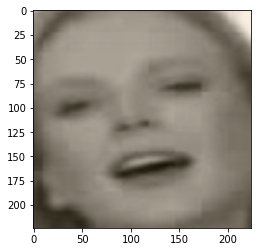

In [66]:
images,label = train_data[0]
print(images.shape) # numframes channels, width, height)
custom_imshow(images[0,:,:,:])

### get model

In [67]:
%cd /content/drive/MyDrive/Deepfake_Detection

/content/drive/MyDrive/Deepfake_Detection


In [68]:
from torchvision import models
import torch
resnet50_pretrained = models.resnet50(pretrained=False)
resnet18_pretrained = models.resnet18(pretrained=False)

In [69]:
checkpoint = torch.load('gray_200epochs_resnet50.tar')

for key in list(checkpoint['state_dict'].keys()):
    name=('.').join(key.split('.')[1:])
    checkpoint['state_dict'][name]=checkpoint['state_dict'].pop(key)
    # 딕셔너리 키 값 변경하기
resnet50_pretrained.load_state_dict(checkpoint['state_dict'],strict=False)

_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=['fc.layers.0.linear.weight', 'fc.layers.0.bn.weight', 'fc.layers.0.bn.bias', 'fc.layers.0.bn.running_mean', 'fc.layers.0.bn.running_var', 'fc.layers.0.bn.num_batches_tracked', 'fc.layers.2.linear.weight', 'fc.layers.2.linear.bias'])

In [70]:
for param in resnet50_pretrained.parameters():
    param.requires_grad=False

In [71]:
import convlstm

In [72]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [73]:
from torch import nn
from torchvision import models
class DetectionModel(nn.Module):
    def __init__(self, num_classes=1,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(DetectionModel, self).__init__()
        self.model = nn.Sequential(*list(resnet50_pretrained.children())[:-2])
        self.lstm = convlstm.ConvLSTM(latent_dim,[2,50,2048], kernel_size=(7, 7),num_layers=3)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)    
        x = self.model(x)
        x = self.avgpool(x) 
        x = x.reshape(batch_size,seq_length,2048,1,1) 
        x_lstm,_ = self.lstm(x,None)
        xx = torch.mean(x_lstm[0],dim = 0)
        xx = self.flatten(xx)
        xx = self.dp(self.linear1(xx))
        xx = self.sigmoid(xx)
        xx = xx.to(torch.float32)

        return xx

In [74]:
model = DetectionModel().to(device)

In [31]:
imus = images.unsqueeze(0)

In [ ]:
imus.shape

torch.Size([1, 50, 3, 224, 224])

In [ ]:
zero_ims = torch.zeros_like(imus).to(device)

In [ ]:
model(zero_ims)

tensor([[0.5000]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [75]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [76]:
loss_fn = nn.BCELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr= 1e-3) 

### for train

In [77]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = torch.squeeze(model(x),1)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [78]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [56]:
epochs = 15

### Train

In [57]:
%cd /content

/content


In [58]:
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    print(f" epoch {epoch + 1}/{epochs}")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in tqdm(enumerate(iter(train_loader))):
        # train_loss
        x, y = batch 
        batch_loss = train_batch(x, y, model, optimizer, loss_fn) 
        train_epoch_losses.append(batch_loss) 

        # accuracy
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)


    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_epoch_accuracy = np.sum([np.sum(i) for i in train_epoch_accuracies])/(2*len(train_epoch_accuracies))

    for ix, batch in enumerate(iter(test_loader)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.sum([np.sum(i) for i in val_epoch_accuracies])/(2*len( val_epoch_accuracies))

    print('val_batch_accuraccy : ',val_epoch_accuracies)
    print('train_epoch_loss : ' , train_epoch_loss)
    print('train_epoch_accuracy : ',  train_epoch_accuracy)
    print('val_epoch_accuraccy : ',  val_epoch_accuracy)


    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

    print('train_Loss: {:.4f} train_Acc: {:.4f} val_Acc: {:.4f}'.format( train_epoch_loss, train_epoch_accuracy, val_epoch_accuracy))


 epoch 1/15


2491it [24:23,  1.70it/s]


val_batch_accuraccy :  [[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, True], [True, True], [True, False], [True, False], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, T

2491it [23:54,  1.74it/s]


val_batch_accuraccy :  [[True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 

2491it [23:51,  1.74it/s]


val_batch_accuraccy :  [[False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tru

2491it [23:51,  1.74it/s]


val_batch_accuraccy :  [[True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True

2491it [23:52,  1.74it/s]


val_batch_accuraccy :  [[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 

2491it [23:52,  1.74it/s]


val_batch_accuraccy :  [[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, Tru

2491it [23:48,  1.74it/s]


val_batch_accuraccy :  [[False, True], [False, True], [False, True], [False, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True,

2491it [23:47,  1.75it/s]


val_batch_accuraccy :  [[True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, T

2491it [23:47,  1.75it/s]


val_batch_accuraccy :  [[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True]

2491it [23:55,  1.74it/s]


val_batch_accuraccy :  [[True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, False], [True, False], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False

2491it [23:53,  1.74it/s]


val_batch_accuraccy :  [[True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, False], [True, False], [False, True], [False, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True,

2491it [23:57,  1.73it/s]


val_batch_accuraccy :  [[True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [False, True], [False, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, T

2491it [24:06,  1.72it/s]


val_batch_accuraccy :  [[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [False, True],

2491it [23:54,  1.74it/s]


val_batch_accuraccy :  [[True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [False, True], [False, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, Tru

2491it [23:56,  1.73it/s]


val_batch_accuraccy :  [[False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [False, True], [False, True], [True, True], [True, True], [True, True], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True,

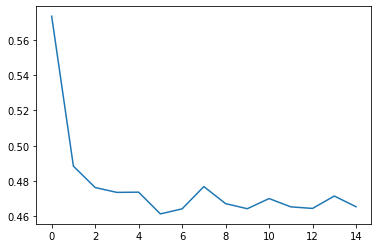

In [60]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

In [61]:
import time
start = time.time()

for ix, batch in enumerate(iter(test_loader)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)     
    val_epoch_accuracies.extend(val_is_correct)
val_accuracy_list = []

for i in val_epoch_accuracies:
    batch_mean = np.sum(i)
    val_accuracy_list.append(batch_mean)
val_epoch_accuracy = sum(val_accuracy_list)/(batchsize*len(val_accuracy_list))


print('val_epoch_accuracy : ',  val_epoch_accuracy)

print("time :", time.time() - start)

val_epoch_accuracy :  0.9117174959871589
time : 212.71361565589905
